# Overview

The task at hand is prediction ication of wine quality

We will use the following different approaches:

- A set of classic classifiers
- A standard neural network (feed fordward nn)
- A bayesian neural network that will take into account epistemic (model) uncertainty on the predicted labels
- A probabilistic neural network that will take into account both aleatoric (data) and epistemic (model) uncertainty on the predicted labels

## Workflow

1. [Data Inspection](#inspection) 
    - Loading
    - Inspection
    - Preprocessing
2. [Modeling](#model-definition)
    - Standard Neural Network
    - Bayesian Neural Network
    - Probabilistic Neural Network
3. [Prediction](#prediction)

In [1]:
# Software install (as required)
#!pip install -r ../requirements.txt

In [51]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

## Data Loading and Inspection <a name="inspection"></a>

In [3]:
def load_data(dataset_name="wine_quality",buffer_size=4998,split="train",batch_size=256,train_size=3000):
    # Data Load
    ds , ds_info = tfds.load(name=dataset_name, as_supervised=True, split=split,with_info=True)
    ds.map(lambda x, y: (x, tf.cast(y, np.float32))).prefetch(buffer_size=buffer_size).cache()
    return ds, ds_info

def split_data(dataset,batch_size=256,train_size=3000):
    # Data Split
    # Train : we shuffle with a buffer the same size as the dataset.
    ds_train = (
        dataset
        .take(train_size)
        .shuffle(buffer_size=train_size)
        .batch(batch_size)
    )
    # Test : no shuffle
    ds_test = (
        dataset
        .skip(train_size)
        .batch(batch_size)
    )

    return ds_train,ds_test


In [4]:
dataset_size = 4898
batch_size = 256
train_size = int(dataset_size * 0.85)

# load data
ds ,ds_info = load_data(
    dataset_name="wine_quality",
    buffer_size=dataset_size, # We prefetch with a buffer the same size as the dataset because th dataset is very small and fits into memory.
    ) 
    
# split data
ds_train,ds_test = split_data(
    dataset=ds,
    batch_size=batch_size,
    train_size=train_size)

In [5]:
# Basic Info
feature_names=list(ds_info.features['features'].keys())
print("Total examples: %d" %(len(ds_train)+len(ds_test)))
print("Train set size: %d" %len(ds_train)) 
print("Test set size : %d" %len(ds_test))   
print("Feature names : %s" %feature_names)

Total examples: 20
Train set size: 17
Test set size : 3
Feature names : ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [6]:
# show a few examples from the train dataset
tfds.as_dataframe(ds_train.unbatch().take(10), ds_info)

2023-05-26 08:43:02.013961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-05-26 08:43:02.014803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-26 08:43:02.310399: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

,features/alcohol,features/chlorides,features/citric acid,features/density,features/fixed acidity,features/free sulfur dioxide,features/pH,features/residual sugar,features/sulphates,features/total sulfur dioxide,features/volatile acidity,quality
0,10.0,0.04399999976158142,0.23999999463558197,0.9972599744796753,7.099999904632568,48.0,3.0399999618530273,12.600000381469727,0.5600000023841858,118.0,0.27000001072883606,7
1,9.100000381469727,0.057999998331069946,0.2800000011920929,0.995199978351593,6.900000095367432,14.0,3.2899999618530273,5.0,0.36000001430511475,146.0,0.1899999976158142,6
2,9.300000190734863,0.03700000047683716,0.2800000011920929,0.9919800162315369,5.800000190734863,43.0,3.240000009536743,0.800000011920929,0.5099999904632568,127.0,0.15000000596046448,5
3,9.100000381469727,0.052000001072883606,0.30000001192092896,0.9980000257492065,6.599999904632568,40.0,3.0199999809265137,14.399999618530273,0.5,183.0,0.25,6
4,9.899999618530273,0.03400000184774399,0.03999999910593033,0.996399998664856,5.699999809265137,22.0,3.2799999713897705,12.600000381469727,0.6299999952316284,115.0,0.38499999046325684,6
5,10.399999618530273,0.04500000178813934,0.4300000071525574,0.9975200295448303,6.599999904632568,53.0,3.5199999809265137,10.899999618530273,0.7699999809265137,154.0,0.1899999976158142,6
6,10.600000381469727,0.03099999949336052,0.3199999928474426,0.9936000108718872,9.100000381469727,15.0,3.0299999713897705,1.100000023841858,0.4099999964237213,151.0,0.27000001072883606,5
7,9.800000190734863,0.04500000178813934,0.25,0.9969099760055542,6.599999904632568,45.0,3.3299999237060547,11.600000381469727,0.4300000071525574,178.0,0.25999999046325684,6
8,11.100000381469727,0.054999999701976776,0.20999999344348907,0.9914000034332275,6.0,42.0,3.319999933242798,1.2999999523162842,0.4300000071525574,168.0,0.28999999165534973,6
9,10.0,0.05400000140070915,0.3799999952316284,0.9945999979972839,7.5,19.0,3.240000009536743,1.7999999523162842,0.4399999976158142,101.0,0.15000000596046448,5


## Classic Regressors

In [55]:
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [56]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.pipeline import Pipeline

In [57]:
regressors = {'Elastic Net': ElasticNet(),
          'Lasso': Lasso(),
          'LinearRegression': LinearRegression(),
          'MLPRegressor': MLPRegressor(),
          'Ridge': Ridge(),
          'LinearSVR': LinearSVR(),
          'RandomForest': RandomForestRegressor(),
          'XGBoost': XGBRegressor(n_estimators=1000,eta=0.1, tree_method='hist'), 
          'SVR': SVR(kernel = 'rbf')}

In [58]:
df = tfds.as_dataframe(ds, ds_info)

2023-05-26 09:28:53.336284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-05-26 09:28:53.336868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


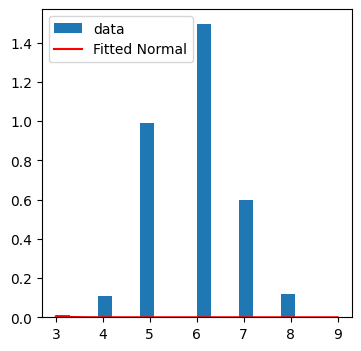

In [59]:
# display target distribution
from scipy.stats import norm
f,ax=plt.subplots(1,1,figsize=(4,4))
df['quality'].hist(bins=20,ax=ax,grid=False,label='data',density=True)
target_values=df['quality'].values
x=np.linspace(min(target_values),max(target_values),50)
ax.plot(x,norm.pdf(x),'r-',label='Fitted Normal')
ax.legend();

In [60]:
X=df[df.columns[:-1]].values
y=df[df.columns[-1:]].values

In [61]:
print(X.shape)
print(y.shape)

(4898, 11)
(4898, 1)


In [63]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [75]:
scores_df=pd.DataFrame(columns=['model','MSE','R2'])
mean_squared_errors = []
root_mean_squared_errors = []
r2_scores = []
for name, regressor in regressors.items():
    pipeline = Pipeline([('scaler', StandardScaler()), (name, regressor)])
    pipeline.fit(X_train,y_train)
    preds = pipeline.predict(X_test)
    mean_squared_errors.append(mean_squared_error(y_test,preds))
    r2_scores.append(r2_score(y_test,preds))

scores_df['model']=regressors.keys()
scores_df['MSE']=mean_squared_errors
scores_df['R2']=r2_scores


/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/c

In [76]:
scores_df.sort_values(by='MSE')

,model,MSE,R2
6,RandomForest,0.395547,0.525842
7,XGBoost,0.409954,0.508572
8,SVR,0.490217,0.412357
3,MLPRegressor,0.508833,0.390042
4,Ridge,0.613019,0.265150
2,LinearRegression,0.613033,0.265133
5,LinearSVR,0.621507,0.254974
0,Elastic Net,0.834804,-0.000713
1,Lasso,0.834804,-0.000713


In [90]:
# Make Predictions
#sample = 10
#indices = np.random.random_integers(low=0,high=len(X_test),size=sample)
pipeline = Pipeline([('scaler', StandardScaler()), ('RandomForest', RandomForestRegressor())])
pipeline.fit(X_train,y_train)
actual=y_test
predicted = pipeline.predict(X_test)
predicted_round=[]
print(predicted)
for idx in range(len(X_test)):
    print(f"Predicted: {round(predicted[idx])} - Actual: {actual[idx]}")
    predicted_round.append(round(predicted[idx]))

/home/codespace/.local/lib/python3.10/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[5.88 5.7  5.08 ... 6.01 4.97 5.67]
Predicted: 6 - Actual: [6]
Predicted: 6 - Actual: [6]
Predicted: 5 - Actual: [4]
Predicted: 5 - Actual: [5]
Predicted: 7 - Actual: [7]
Predicted: 6 - Actual: [6]
Predicted: 7 - Actual: [7]
Predicted: 6 - Actual: [5]
Predicted: 7 - Actual: [7]
Predicted: 6 - Actual: [6]
Predicted: 5 - Actual: [5]
Predicted: 6 - Actual: [6]
Predicted: 6 - Actual: [5]
Predicted: 5 - Actual: [5]
Predicted: 7 - Actual: [7]
Predicted: 6 - Actual: [5]
Predicted: 7 - Actual: [7]
Predicted: 6 - Actual: [6]
Predicted: 5 - Actual: [6]
Predicted: 6 - Actual: [6]
Predicted: 7 - Actual: [8]
Predicted: 6 - Actual: [5]
Predicted: 5 - Actual: [5]
Predicted: 6 - Actual: [7]
Predicted: 6 - Actual: [6]
Predicted: 5 - Actual: [5]
Predicted: 6 - Actual: [7]
Predicted: 5 - Actual: [5]
Predicted: 6 - Actual: [6]
Predicted: 7 - Actual: [7]
Predicted: 6 - Actual: [5]
Predicted: 6 - Actual: [8]
Predicted: 7 - Actual: [7]
Predicted: 7 - Actual: [7]
Predicted: 7 - Actual: [7]
Predicted: 7 - Actu

In [91]:
def root_mean_squared_error(y_pred,y_true):
    values=[]
    for i in range(len(y_pred)):
        values.append(pow(y_true[i]-y_pred[i],2))
    return np.sqrt(sum(values)/len(y_pred))

In [92]:
print('RMSE : ',root_mean_squared_error(predicted_round,actual))

RMSE :  [0.68647144]


In [6]:
# Class balance check : is the dataset imbalanced?
#fig, ax = plt.subplots(1, 1, figsize=(10,6))
#labels, counts = np.unique(np.fromiter(ds.unbatch().map(lambda x, y: y), np.int32),  return_counts=True)
#ax.set_xlabel('Counts')
#ax.set_title("Counts by type");
#sns.barplot(x=counts, y=[class_names[l] for l in labels], label="Total")
#ax.grid(True,ls='--')
#sns.despine(left=True, bottom=True)

In [7]:
# IF needed
def prepare_for_training(ds, cache=True, batch_size=1, shuffle_buffer_size=1000):
  ds = ds.map(lambda x, y: (x, tf.cast(y, tf.float32)))
  ds = ds.prefetch(buffer_size=4898)
  ds = ds.cache()
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model is training.
  return ds

In [23]:
# Function to create model inputs
def create_model_inputs(feature_names=[]):
    inputs = {}
    for name in feature_names:
        print('creating model input layer for : %s' %name)
        inputs[name] = layers.Input(
            name=name.replace(" ","_"), shape=(1,), dtype=tf.float32
        )
    return inputs

# Create Standard Neural Network
def base_neural_network(hidden_units=None,inputs=None,feature_names=[]):
    if inputs is None:
        inputs = create_model_inputs(feature_names=feature_names)
    input_values = [value for _, value in sorted(inputs.items())]
    features = keras.layers.concatenate(input_values)
    features = layers.BatchNormalization()(features)

    # Create hidden layers with deterministic weights using the Dense layer.
    for units in hidden_units:
        features = layers.Dense(units, activation="sigmoid")(features)
    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)

    model = keras.Model(inputs=inputs, outputs=outputs,name='StandardNeuralNet')
    return model

# Create Bayesian Neural Network : to capture epistemic (model) uncertainty due to limited training data
def bayesian_neural_network(train_size=1000,hidden_units=None,inputs=None,feature_names=[],activation='sigmoid'):
    if inputs is None:
        inputs = create_model_inputs(feature_names=feature_names)
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation=activation,
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs,name='BayesNeuralNet')
    return model

# Create Probabilistics Neural Network : to capture epistemic (model) uncertainty due to limited training data and aleatoric (data) uncertainty due to randomness
def probabilistic_neural_network(train_size=1000,hidden_units=None,inputs=None,feature_names=[],activation='sigmoid'):
    if inputs is None:
        inputs = create_model_inputs(feature_names=feature_names)
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation=activation,
        )(features)

    # Create a probabilistic output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)
    model = keras.Model(inputs=inputs, outputs=outputs,name='ProbabilisticNeuralNet')
    return model

# Function to define a prior model in the context of Bayesian inference
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

# Function to define a posterior model in the context of Bayesian inference
# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means, variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

# Since the output of the probabilistic neural network is a distribution, rather than a point estimate, 
# we use the negative loglikelihood as our loss function to compute how likely to see the true data (targets) 
# from the estimated distribution produced by the model.
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(float(targets))

# Function to train and evaluate a model (experiment run)
def run_experiment(model, loss, train_dataset, test_dataset, num_epochs, learning_rate):

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Model training started ...")
    history = model.fit(
        train_dataset, 
        epochs=num_epochs, 
        validation_data=test_dataset)
    
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")
    
    plot_training(history=history,learning_rate=learning_rate)

    return model

# Function to plot the training history
def plot_training(history,alpha=1.,learning_rate=0.01,figsize=(8,6)):
    # PLot training history for loss
    title= history.model.name + ' learning rate :' + str(learning_rate)
    f,ax=plt.subplots(1,1,figsize=figsize)
    ax.plot(history.history['loss'],label='Train Loss',alpha=alpha)
    ax.plot(history.history['val_loss'],label='Val Loss',alpha=alpha)
    plt.title(title)
    plt.ylabel('loss',fontsize=10)
    plt.xlabel('epoch',fontsize=10)
    plt.legend(loc='upper right',fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

### Train Base Neural Network <a name="model training"></a>

creating model input layer for : fixed acidity
creating model input layer for : volatile acidity
creating model input layer for : citric acid
creating model input layer for : residual sugar
creating model input layer for : chlorides
creating model input layer for : free sulfur dioxide
creating model input layer for : total sulfur dioxide
creating model input layer for : density
creating model input layer for : pH
creating model input layer for : sulphates
creating model input layer for : alcohol
Model training started ...
Epoch 1/100
17/17 [==============================] - 1s 10ms/step - loss: 37.3241 - root_mean_squared_error: 6.1093 - val_loss: 36.5263 - val_root_mean_squared_error: 6.0437
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 35.1152 - root_mean_squared_error: 5.9258 - val_loss: 34.5501 - val_root_mean_squared_error: 5.8779
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 33.2438 - root_mean_squared_error: 5.7657 - val_loss

INFO:tensorflow:Assets written to: ../models/standard_neural_network/assets


INFO:tensorflow:Assets written to: ../models/standard_neural_network/assets


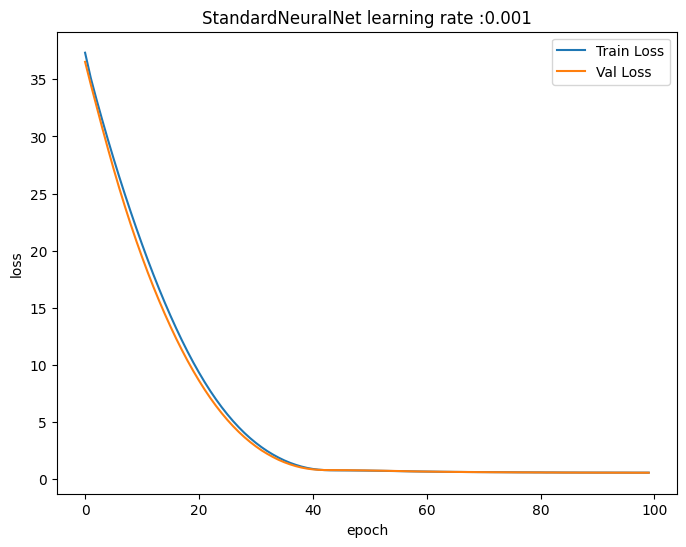

In [13]:
hidden_units = [8, 8]
learning_rate = 0.001
num_epochs = 100
standard = base_neural_network(hidden_units=hidden_units,feature_names=feature_names)
trained_model = run_experiment(
    model=standard, 
    loss=keras.losses.MeanSquaredError(), 
    train_dataset=ds_train, 
    test_dataset=ds_test,
    num_epochs=num_epochs,
    learning_rate=learning_rate)

# save 
trained_model.save("../models/standard_neural_network")

We take a sample from the test set use the model to obtain predictions for them. 

Note that since the baseline model is deterministic, we get a single a point estimate prediction for each test example, with no information about the uncertainty of the model nor the prediction.

### Make some predictions

In [14]:

sample = 10
examples, targets = list(ds_test.unbatch().shuffle(batch_size * 10).batch(sample))[
    0
]

predicted = standard(examples).numpy()
for idx in range(sample):
    print(f"Predicted: {round(float(predicted[idx][0]), 1)} - Actual: {targets[idx]}")

Predicted: 6.1 - Actual: 6
Predicted: 5.6 - Actual: 5
Predicted: 5.7 - Actual: 7
Predicted: 5.6 - Actual: 5
Predicted: 6.6 - Actual: 8
Predicted: 5.6 - Actual: 5
Predicted: 6.0 - Actual: 6
Predicted: 6.6 - Actual: 7
Predicted: 6.3 - Actual: 7
Predicted: 6.2 - Actual: 5


2023-05-25 17:23:32.751097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-25 17:23:32.751717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


### Train Bayesian Neural Network on small sample

creating model input layer for : fixed acidity
creating model input layer for : volatile acidity
creating model input layer for : citric acid
creating model input layer for : residual sugar
creating model input layer for : chlorides
creating model input layer for : free sulfur dioxide
creating model input layer for : total sulfur dioxide
creating model input layer for : density
creating model input layer for : pH
creating model input layer for : sulphates
creating model input layer for : alcohol
Model training started ...
Epoch 1/500


2023-05-25 17:24:19.943522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-25 17:24:19.944094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


5/5 [==============================] - 3s 257ms/step - loss: 41.9698 - root_mean_squared_error: 6.4771 - val_loss: 48.8345 - val_root_mean_squared_error: 6.9873
Epoch 2/500
5/5 [==============================] - 0s 13ms/step - loss: 40.7992 - root_mean_squared_error: 6.3863 - val_loss: 36.4104 - val_root_mean_squared_error: 6.0329
Epoch 3/500
5/5 [==============================] - 0s 13ms/step - loss: 39.6219 - root_mean_squared_error: 6.2933 - val_loss: 46.6288 - val_root_mean_squared_error: 6.8272
Epoch 4/500
5/5 [==============================] - 0s 15ms/step - loss: 42.5074 - root_mean_squared_error: 6.5189 - val_loss: 39.3028 - val_root_mean_squared_error: 6.2682
Epoch 5/500
5/5 [==============================] - 0s 14ms/step - loss: 40.2845 - root_mean_squared_error: 6.3458 - val_loss: 39.9546 - val_root_mean_squared_error: 6.3198
Epoch 6/500
5/5 [==============================] - 0s 14ms/step - loss: 41.6041 - root_mean_squared_error: 6.4491 - val_loss: 39.3417 - val_root_mean_s

INFO:tensorflow:Assets written to: ../models/bayesian_neural_network_1/assets


INFO:tensorflow:Assets written to: ../models/bayesian_neural_network_1/assets


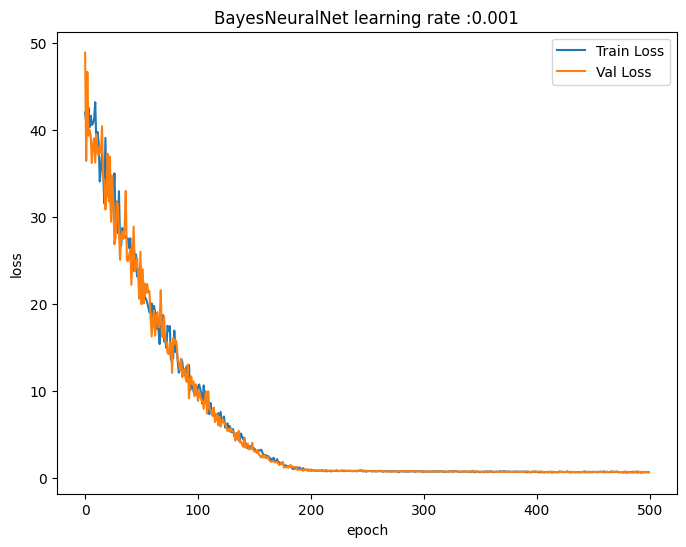

In [15]:
num_epochs = 500
small_train_size = int(train_size * 0.3)
small_train_dataset = ds_train.unbatch().take(small_train_size).batch(batch_size)

# build
bayesian_1 = bayesian_neural_network(
    hidden_units=hidden_units,
    feature_names=feature_names,
    train_size=small_train_size)
# train
trained_model = run_experiment(
    model=bayesian_1, 
    loss=keras.losses.MeanSquaredError(), 
    train_dataset=small_train_dataset, 
    test_dataset=ds_test,
    num_epochs=num_epochs,
    learning_rate=learning_rate)

# save 
trained_model.save("../models/bayesian_neural_network_1")

In [16]:
from statistics import NormalDist

def compute_predictions(model, input=None, iterations=100 , n_samples=10):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(input).numpy())
    predicted = np.concatenate(predicted, axis=1)

    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_std = np.std(predicted, axis=1).tolist()
    #prediction_min = np.min(predicted, axis=1).tolist()
    #prediction_max = np.max(predicted, axis=1).tolist()
    #prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()

    for idx in range(n_samples):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"Predictions  std: {round(prediction_std[idx], 2)}, "
            f"Actual: {targets[idx]}"
        )

    return predicted

def display_predictions(predictions=[], target_values=[], n_samples=10,n_bins=10,figsize=(15,6),n_rows=2,n_cols=5):
    f,axs=plt.subplots(n_rows,n_cols,figsize=figsize)
    k=0
    for i in range(n_rows):
        for j in range(n_cols):
            data=list(predictions[k])
            # normal distribution from the data
            norm = NormalDist.from_samples(data)
            mu = norm.mean
            sigma = norm.stdev
            # plot the predictions
            axs[i][j].hist(data, n_bins, density=True, alpha=0.5,label='Predictions')
            # add the fitted normal distribution line
            x = np.linspace(min(data),max(data),50)
            pdf = [norm.pdf(i) for i in x]
            axs[i][j].plot(x, pdf, 'b', linewidth=1)
            title='Predictions'
            axs[i][j].set_title(title,fontsize=8)
            # add the true target value
            axs[i][j].axvline(x=target_values[k],color='red',lw=2,label='True value')
            axs[i][j].legend(loc='upper right',fontsize=8)
            k+=1

Predictions mean: 5.91, Predictions  std: 0.23, Actual: 6
Predictions mean: 5.5, Predictions  std: 0.3, Actual: 5
Predictions mean: 5.86, Predictions  std: 0.17, Actual: 7
Predictions mean: 5.73, Predictions  std: 0.24, Actual: 5
Predictions mean: 6.29, Predictions  std: 0.1, Actual: 8
Predictions mean: 5.66, Predictions  std: 0.25, Actual: 5
Predictions mean: 6.1, Predictions  std: 0.14, Actual: 6
Predictions mean: 6.3, Predictions  std: 0.1, Actual: 7
Predictions mean: 6.16, Predictions  std: 0.14, Actual: 7
Predictions mean: 6.17, Predictions  std: 0.16, Actual: 5


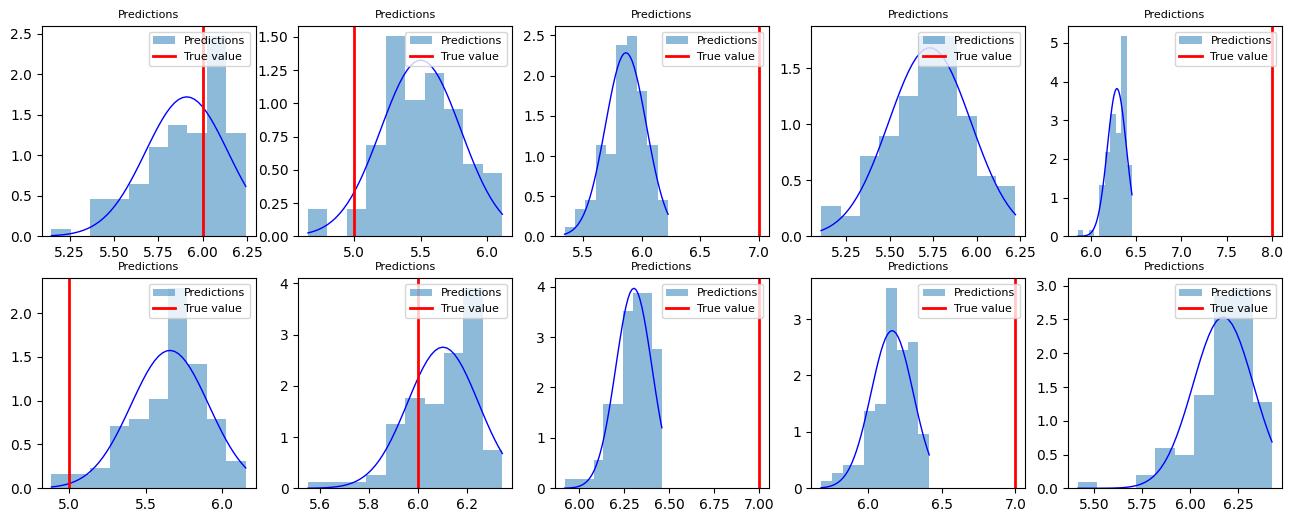

In [17]:
predictions=compute_predictions(
    model=bayesian_1,
    input=examples,
    )

display_predictions(
    predictions=predictions,
    target_values=targets,
    figsize=(16,6))

### Train Bayesian Neural Network on Full sample

creating model input layer for : fixed acidity
creating model input layer for : volatile acidity
creating model input layer for : citric acid
creating model input layer for : residual sugar
creating model input layer for : chlorides
creating model input layer for : free sulfur dioxide
creating model input layer for : total sulfur dioxide
creating model input layer for : density
creating model input layer for : pH
creating model input layer for : sulphates
creating model input layer for : alcohol
Model training started ...
Epoch 1/500
17/17 [==============================] - 2s 36ms/step - loss: 35.6443 - root_mean_squared_error: 5.9699 - val_loss: 31.6707 - val_root_mean_squared_error: 5.6274
Epoch 2/500
17/17 [==============================] - 0s 4ms/step - loss: 32.4822 - root_mean_squared_error: 5.6989 - val_loss: 29.9304 - val_root_mean_squared_error: 5.4705
Epoch 3/500
17/17 [==============================] - 0s 4ms/step - loss: 33.4120 - root_mean_squared_error: 5.7799 - val_loss

INFO:tensorflow:Assets written to: ../models/bayesian_neural_network_2/assets


INFO:tensorflow:Assets written to: ../models/bayesian_neural_network_2/assets


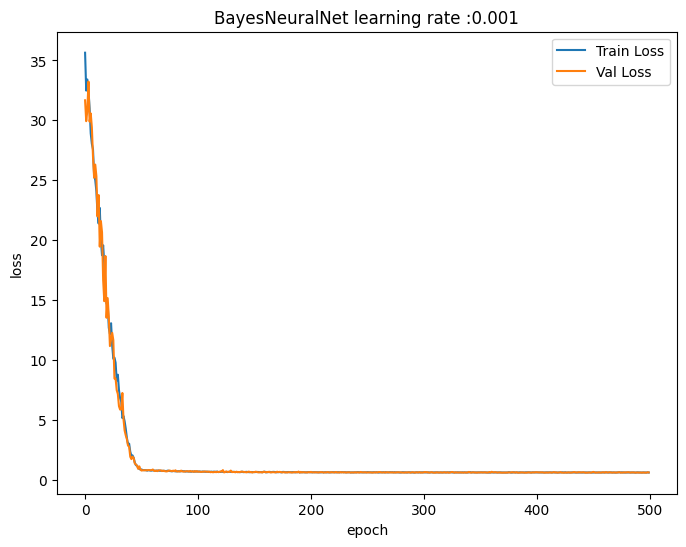

In [21]:
num_epochs = 500

# build
bayesian_2 = bayesian_neural_network(
    hidden_units=hidden_units,
    feature_names=feature_names,
    train_size=train_size)
# train
trained_model = run_experiment(
    model=bayesian_2, 
    loss=keras.losses.MeanSquaredError(), 
    train_dataset=ds_train, 
    test_dataset=ds_test,
    num_epochs=num_epochs,
    learning_rate=learning_rate)

# save 
trained_model.save("../models/bayesian_neural_network_2")

Predictions mean: 5.95, Predictions  std: 0.18, Actual: 6
Predictions mean: 5.6, Predictions  std: 0.21, Actual: 5
Predictions mean: 5.7, Predictions  std: 0.12, Actual: 7
Predictions mean: 5.64, Predictions  std: 0.13, Actual: 5
Predictions mean: 6.53, Predictions  std: 0.07, Actual: 8
Predictions mean: 5.65, Predictions  std: 0.19, Actual: 5
Predictions mean: 6.12, Predictions  std: 0.13, Actual: 6
Predictions mean: 6.58, Predictions  std: 0.06, Actual: 7
Predictions mean: 6.37, Predictions  std: 0.09, Actual: 7
Predictions mean: 6.32, Predictions  std: 0.12, Actual: 5


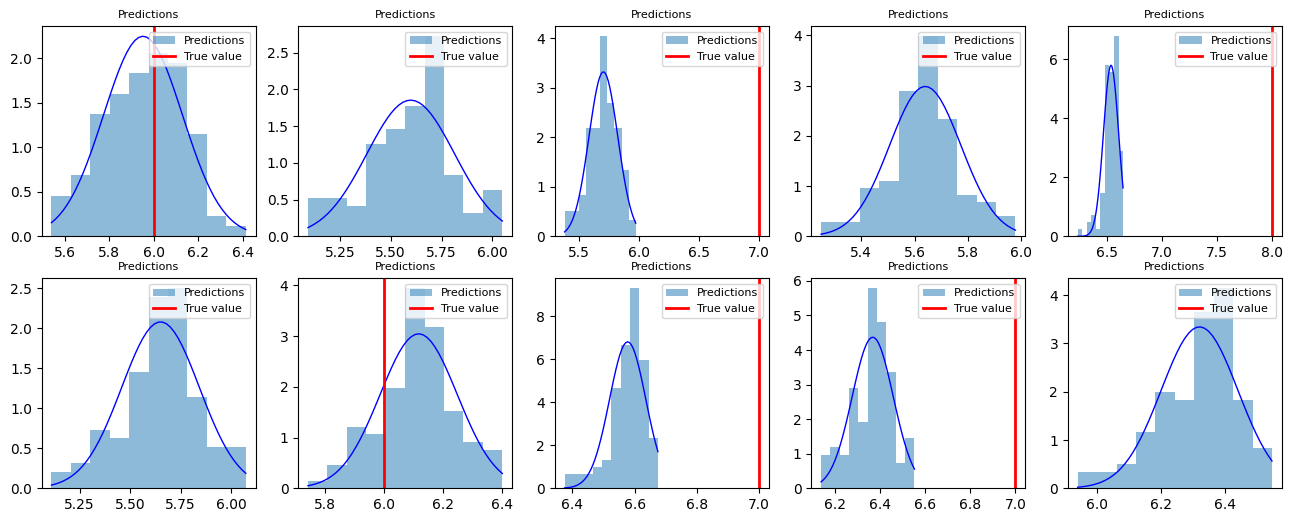

In [22]:
predictions=compute_predictions(
    model=bayesian_2,
    input=examples,
    )

display_predictions(
    predictions=predictions,
    target_values=targets,
    figsize=(16,6))

### Train Probabilistic Neural Network 

creating model input layer for : fixed acidity
creating model input layer for : volatile acidity
creating model input layer for : citric acid
creating model input layer for : residual sugar
creating model input layer for : chlorides
creating model input layer for : free sulfur dioxide
creating model input layer for : total sulfur dioxide
creating model input layer for : density
creating model input layer for : pH
creating model input layer for : sulphates
creating model input layer for : alcohol
Model training started ...
Epoch 1/1000


/tmp/__autograph_generated_filedxl3x6eo.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  retval_ = -ag__.converted_call(ag__.ld(estimated_distribution).log_prob, (ag__.converted_call(ag__.ld(np).float, (ag__.ld(targets),), None, fscope),), None, fscope)


17/17 [==============================] - 2s 37ms/step - loss: 24.8213 - root_mean_squared_error: 6.1516 - val_loss: 21.3541 - val_root_mean_squared_error: 6.0162
Epoch 2/1000
17/17 [==============================] - 0s 4ms/step - loss: 21.2560 - root_mean_squared_error: 6.0773 - val_loss: 22.6061 - val_root_mean_squared_error: 5.8513
Epoch 3/1000
17/17 [==============================] - 0s 4ms/step - loss: 18.1200 - root_mean_squared_error: 5.8630 - val_loss: 14.2414 - val_root_mean_squared_error: 6.2249
Epoch 4/1000
17/17 [==============================] - 0s 5ms/step - loss: 17.0474 - root_mean_squared_error: 5.7787 - val_loss: 11.1839 - val_root_mean_squared_error: 5.3730
Epoch 5/1000
17/17 [==============================] - 0s 4ms/step - loss: 13.6302 - root_mean_squared_error: 5.8034 - val_loss: 11.6526 - val_root_mean_squared_error: 5.9688
Epoch 6/1000
17/17 [==============================] - 0s 5ms/step - loss: 13.4200 - root_mean_squared_error: 5.6983 - val_loss: 10.5587 - val_

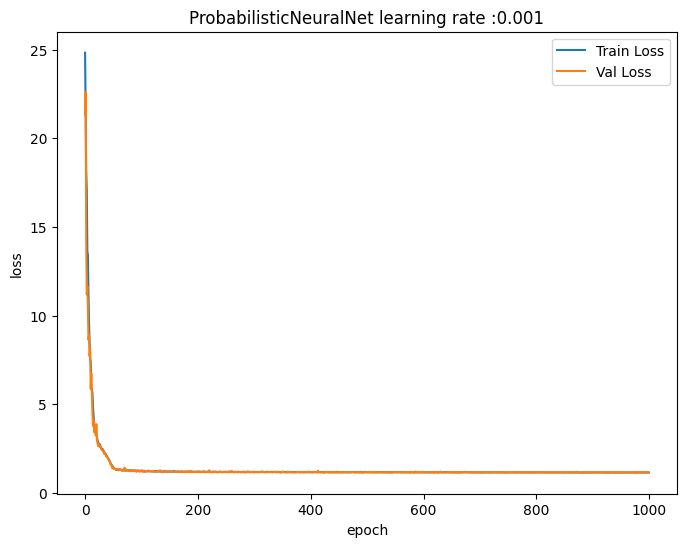

In [24]:
num_epochs = 500

# build
probabilistic = probabilistic_neural_network(
    hidden_units=hidden_units,
    feature_names=feature_names,
    train_size=train_size)

# train
trained_model = run_experiment(
    model=probabilistic, 
    loss=negative_loglikelihood, 
    train_dataset=ds_train, 
    test_dataset=ds_test,
    num_epochs=num_epochs,
    learning_rate=learning_rate)

# save 
trained_model.save("../models/probabilistic_neural_network_2")

In [25]:
prediction_distribution = probabilistic(examples)
prediction_mean = prediction_distribution.mean().numpy().tolist()
prediction_stdv = prediction_distribution.stddev().numpy()

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

for idx in range(sample):
    print(
        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv[idx][0], 2)}, "
        f"95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]"
        f" - Actual: {targets[idx]}"
    )


Prediction mean: 5.87, stddev: 0.71, 95% CI: [7.26 - 4.48] - Actual: 6
Prediction mean: 5.37, stddev: 0.66, 95% CI: [6.67 - 4.06] - Actual: 5
Prediction mean: 5.62, stddev: 0.7, 95% CI: [6.99 - 4.26] - Actual: 7
Prediction mean: 5.5, stddev: 0.69, 95% CI: [6.84 - 4.15] - Actual: 5
Prediction mean: 6.41, stddev: 0.79, 95% CI: [7.96 - 4.86] - Actual: 8
Prediction mean: 5.47, stddev: 0.67, 95% CI: [6.78 - 4.16] - Actual: 5
Prediction mean: 5.93, stddev: 0.71, 95% CI: [7.32 - 4.54] - Actual: 6
Prediction mean: 6.42, stddev: 0.79, 95% CI: [7.98 - 4.87] - Actual: 7
Prediction mean: 6.33, stddev: 0.78, 95% CI: [7.85 - 4.8] - Actual: 7
Prediction mean: 6.06, stddev: 0.73, 95% CI: [7.49 - 4.64] - Actual: 5
